# Chapter 9
##  $\begin{aligned} y_t = SARIMAX(p,d,q)(P,D,Q)_m + \sum_{i=1}^n \beta_i X^i_t \end{aligned}$ 

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from pathlib import Path

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt
import omdutils as omd

importlib.reload(tt)

path = Path('/home/oliver/Documents/Data')
print('timetools version: {}'.format(tt.__version__))
print('omdutils version: {}'.format(omd.__version__))
print('statsmodels version: {}'.format(sm.__version__))

timetools version: 10.09.2022
omdutils version: 8.6.2022
statsmodels version: 0.13.2


### GDP = C + G + I + NX

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
qs = macro_econ_data['year'].astype(int).astype(str) + '-Q' + macro_econ_data['quarter'].astype(int).astype(str)
macro_econ_data['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
macro_econ_data.drop(columns=['year', 'quarter'], axis=1, inplace=True)
omd.to_sqlite(macro_econ_data, 'macro_econ_data', str(path / 'Datasets'))
macro_econ_data

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,date
0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1959-01-01
1,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,1959-04-01
2,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,1959-07-01
3,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,1959-10-01
4,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1960-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,2008-07-01
199,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,2008-10-01
200,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,2009-01-01
201,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,2009-04-01


In [6]:
df = omd.from_sqlite('select * from macro_econ_data', str(path / 'Datasets'))
df['date'] = pd.to_datetime(df['date']).dt.date
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 1959-01-01 to 2009-07-01
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   realgdp   203 non-null    float64
 1   realcons  203 non-null    float64
 2   realinv   203 non-null    float64
 3   realgovt  203 non-null    float64
 4   realdpi   203 non-null    float64
 5   cpi       203 non-null    float64
 6   m1        203 non-null    float64
 7   tbilrate  203 non-null    float64
 8   unemp     203 non-null    float64
 9   pop       203 non-null    float64
 10  infl      203 non-null    float64
 11  realint   203 non-null    float64
dtypes: float64(12)
memory usage: 20.6+ KB


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


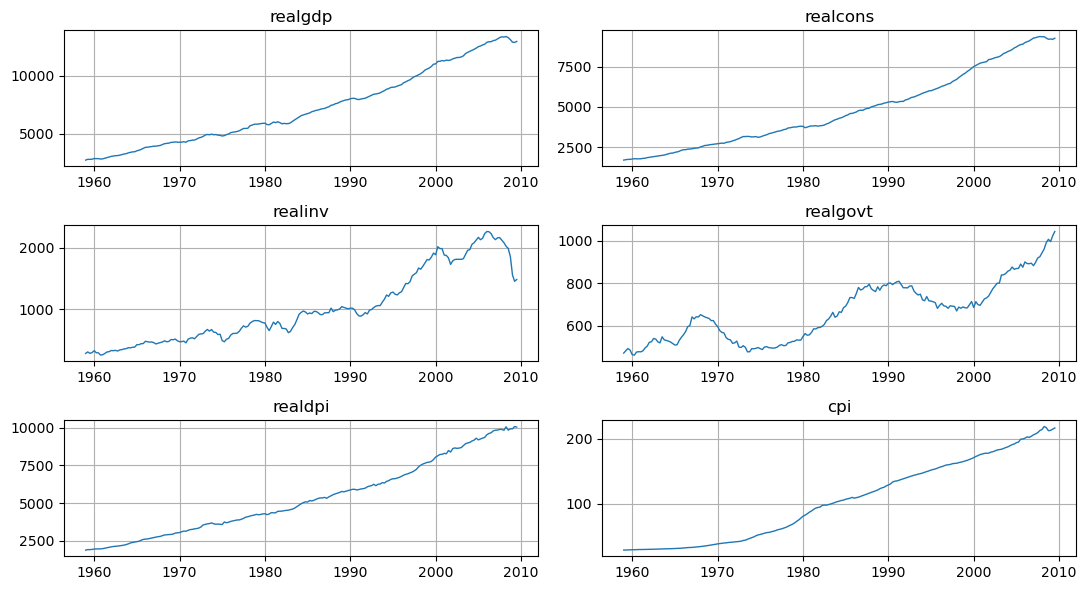

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(11, 6))
for i, ax in enumerate(axes.flatten()[:6]):
    data = df[df.columns[i]]
    ax.plot(data, lw=1)
    ax.set_title(df.columns[i])
    ax.grid(True)

plt.tight_layout()

## Stationarity

In [8]:
tt.adf_v2(df['realgdp'], diff=0)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                   1.750463
p-value                          0.998246
#Lags Used                      12.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64

The time series is not stationary.


In [9]:
tt.adf_v2(df['realgdp'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                -6.305696e+00
p-value                        3.327882e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.000000e+02
Critical Value (1%)           -3.463476e+00
Critical Value (5%)           -2.876102e+00
Critical Value (10%)          -2.574532e+00
dtype: float64

The time series is stationary.


## Best fit (AIC)

In [10]:
p = range(0, 5, 1)
d = 1
q = range(0,5, 1)

P = [0]
D = 0
Q = [0]

s = 4

parameters_list = list(product(p, q, P, Q))
parameters_list

[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0)]

In [11]:
df_train = df['realgdp'][:-4]

In [12]:
tt.optimize_SARIMA(df_train, parameters_list, d, D, s=s)

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 0, 0)",2125.467246
1,"(3, 3, 0, 0)",2126.021102
2,"(3, 2, 0, 0)",2126.915116
3,"(1, 3, 0, 0)",2127.196745
4,"(4, 1, 0, 0)",2127.217831
5,"(4, 3, 0, 0)",2128.135861
6,"(2, 3, 0, 0)",2128.233558
7,"(1, 4, 0, 0)",2128.673368
8,"(4, 2, 0, 0)",2129.241768
9,"(2, 4, 0, 0)",2131.087794


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  199
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1057.734
Date:                Thu, 13 Oct 2022   AIC                           2125.467
Time:                        21:36:34   BIC                           2141.909
Sample:                    01-01-1959   HQIC                          2132.122
                         - 07-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2112      0.076     16.009      0.000       1.063       1.360
ar.L2          0.0109      0.102      0.106      0.915      -0.190       0.211
ar.L3         -0.2226      0.062     -3.586      0.0

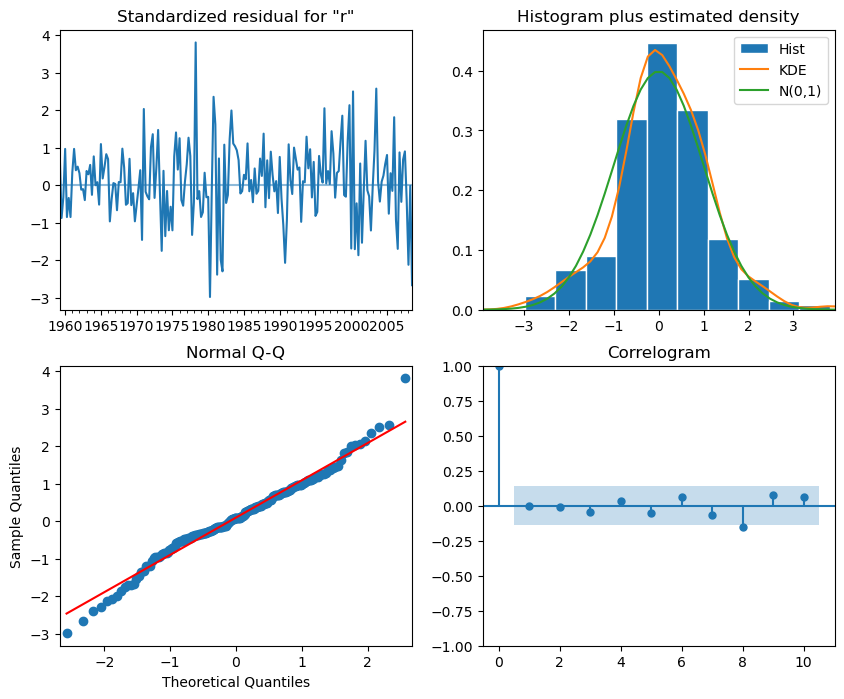

In [13]:
ARIMA_model = SARIMAX(df_train, order=(3,1,1), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
print(ARIMA_model_fit.summary())
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.80 > 0.05
The residuals are independent and not correlated.  Like white noise!


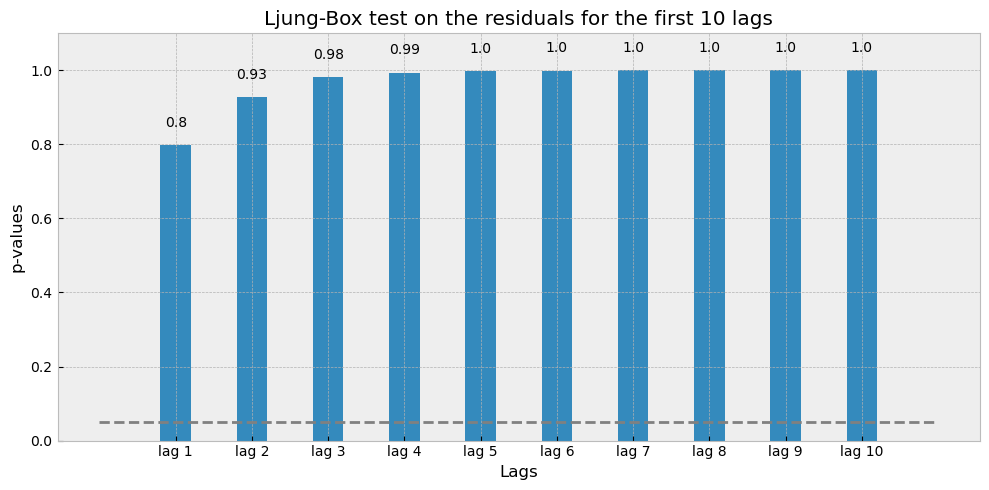

In [14]:
tt.ljungbox(np.array(ARIMA_model_fit.resid), lags=10)

## Prediction

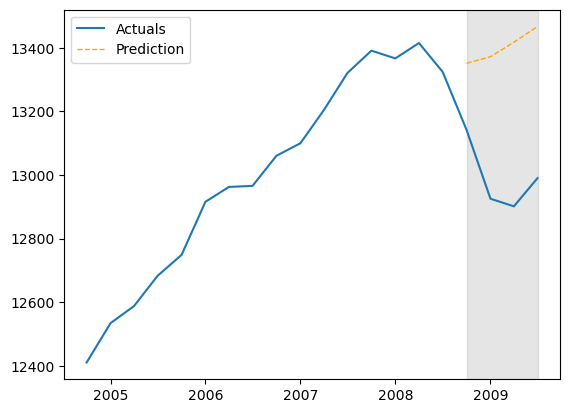

In [15]:
plt.plot(df[-20:]['realgdp'], label='Actuals')
plt.plot(ARIMA_model_fit.forecast(4), 
    label='Prediction', ls='--', lw='1', color='orange')
plt.axvspan('2008-10-01', '2009-07-01', color='#808080', alpha=0.2)
plt.legend();

## Seasonality 
There is seasonality but it accounts for nearly nothing (see y-axis of Seasonality graph).

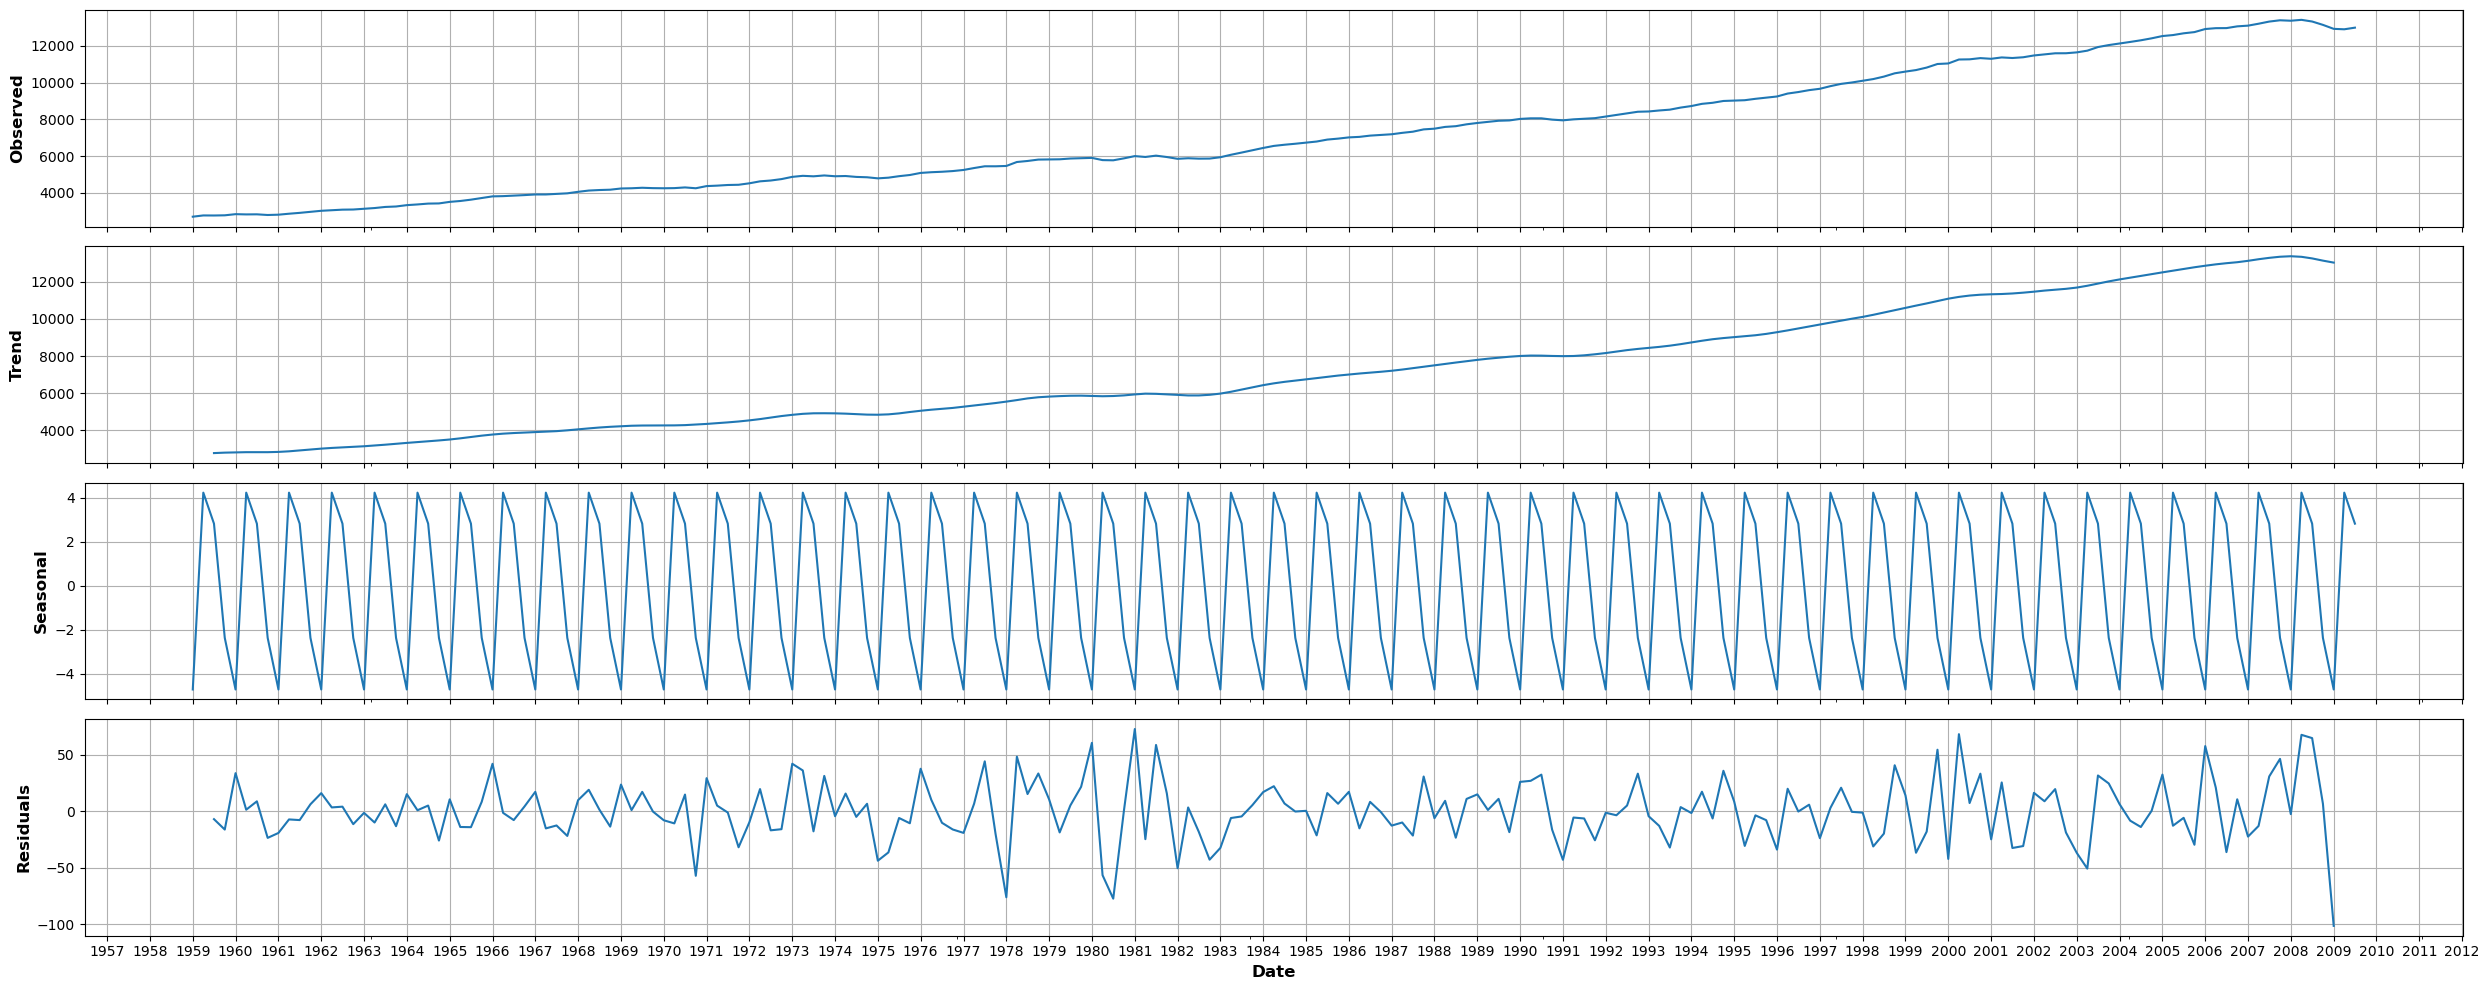

In [16]:
tt.seasonal_decomp(df['realgdp'], period=4)

## Exogenous variables 

In [17]:
exog = ['realcons', 'realinv', 'realgovt', 'realdpi']
df_exog = df[exog]
df_exog_train = df_exog[:-4]

In [18]:
tt.optimize_SARIMAX(df_train, df_exog_train, parameters_list, d, D, s)

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 0)",1744.584975
1,"(4, 3, 0, 0)",1745.317498
2,"(4, 4, 0, 0)",1746.528636
3,"(3, 3, 0, 0)",1746.994856
4,"(3, 4, 0, 0)",1747.589708
5,"(1, 4, 0, 0)",1750.877538
6,"(1, 2, 0, 0)",1751.369242
7,"(4, 0, 0, 0)",1751.982422
8,"(2, 1, 0, 0)",1752.234589
9,"(1, 3, 0, 0)",1752.515683


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  199
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -863.292
Date:                Thu, 13 Oct 2022   AIC                           1744.585
Time:                        21:36:43   BIC                           1774.179
Sample:                    01-01-1959   HQIC                          1756.564
                         - 07-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       1.0177      0.046     21.926      0.000       0.927       1.109
realinv        1.0230      0.037     27.388      0.000       0.950       1.096
realgovt       0.7940      0.133      5.984      0.0

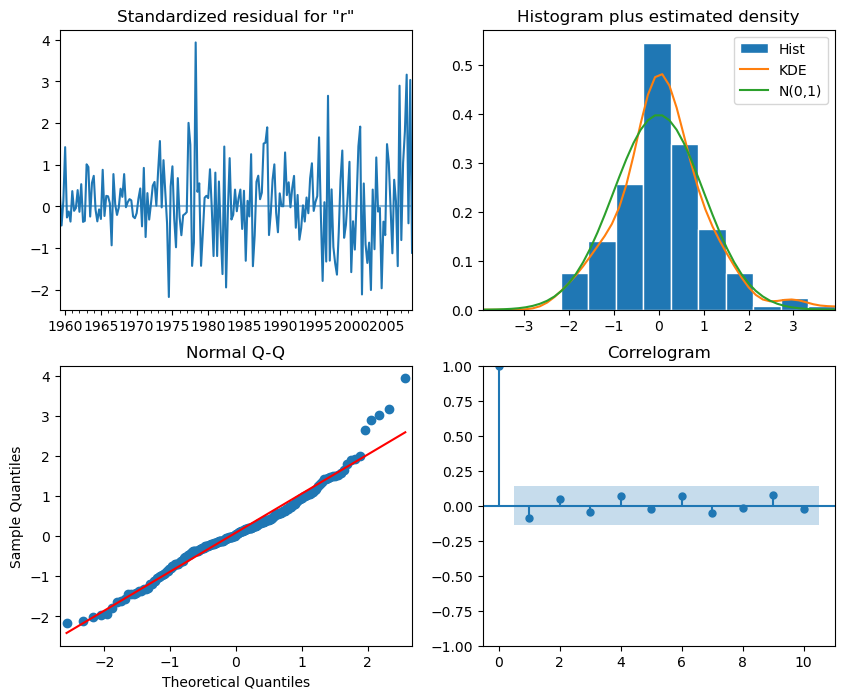

In [19]:
ARIMAX_model = SARIMAX(endog=df_train, exog=df_exog_train, order=(2,1,2), seasonal_order=(0,0,0,4), simple_differencing=False)
ARIMAX_model_fit = ARIMAX_model.fit(disp=False)
print(ARIMAX_model_fit.summary())
ARIMAX_model_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.65 > 0.05
The residuals are independent and not correlated.  Like white noise!


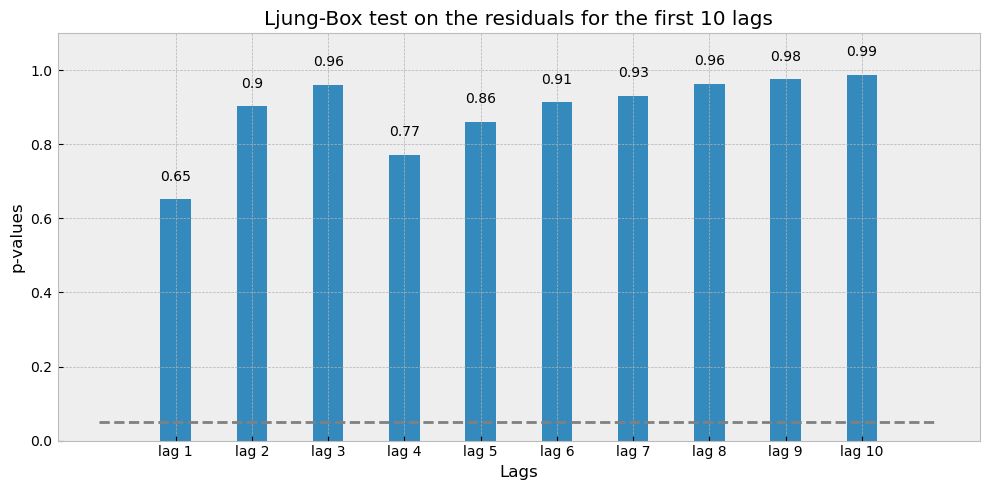

In [20]:
tt.ljungbox(np.array(ARIMAX_model_fit.resid), lags=10)

## Prediction

In [132]:
import datetime
xmin = datetime.datetime(2008, 10, 1)
xmax = datetime.datetime(2009, 7, 1)

In [128]:
df[-5:-4].index

Index([2008-07-01], dtype='object', name='date')

In [ ]:
plt.plot(x=df[-5:-4].index, y=df[-5:-4]['realgdp'].tolist() * 4);

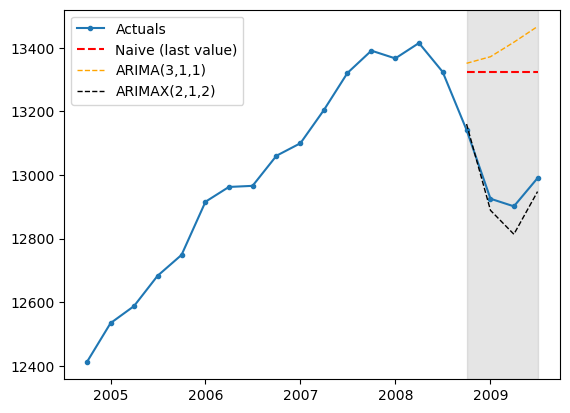

In [144]:
plt.plot(df[-20:]['realgdp'], label='Actuals', marker='o', ms=3)

df_naive = pd.DataFrame(df[-5:-4]['realgdp'].values.tolist() * 4, 
    index=df_exog[-4:].index, columns=['Forecast'])

plt.plot(df_naive, label='Naive (last value)', color='red', ls='--')

plt.plot(ARIMA_model_fit.forecast(4), 
    label='ARIMA(3,1,1)', ls='--', lw='1', color='orange')

df_exog_test = df_exog[-4:]
plt.plot(ARIMAX_model_fit.forecast(4, exog=df_exog_test),
    label='ARIMAX(2,1,2)', ls='--', lw='1', color='black')

plt.axvspan('2008-10-01', '2009-07-01', color='#808080', alpha=0.2)
plt.legend();

## Model performance comparison

In [111]:
mape_naive = tt.mape(df[-4:]['realgdp'].values, df[-5:-4]['realgdp'].values.tolist() * 4)
mape_ARIMA = tt.mape(df[-4:]['realgdp'].values, ARIMA_model_fit.forecast(4).values)
mape_ARIMAX = tt.mape(df[-4:]['realgdp'].values, ARIMAX_model_fit.forecast(4, exog=df_exog_test).values)

x = ['Naive (last value)', 'ARIMA(3,1,1)', 'ARIMAX(2,1,2)']
y = [mape_naive, mape_ARIMA, mape_ARIMAX]

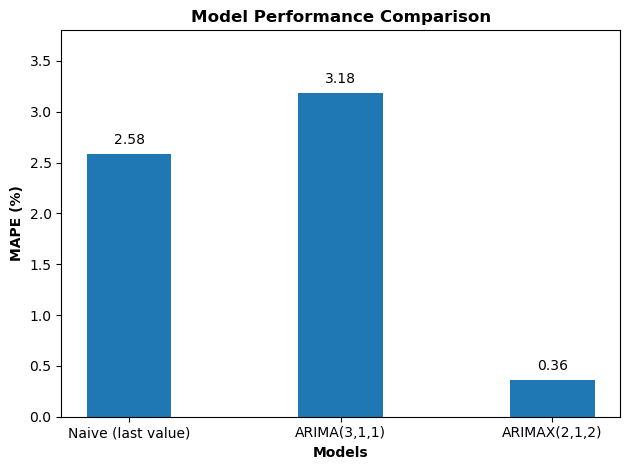

In [116]:
tt.plot_mapes(x, y, height=3.8, bar_label_height=0.1)

# Use all variables as exogenous variables

In [145]:
df

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-10-01,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-01-01,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


In [146]:
exog_all = ['realcons', 'realinv', 'realgovt', 'realdpi','cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']
df_exog_all = df[exog_all]
df_exog_all_train = df_exog_all[:-4]

In [147]:
tt.optimize_SARIMAX(df_train, df_exog_all_train, parameters_list, d, D, s)

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(4, 4, 0, 0)",1747.955569
1,"(3, 3, 0, 0)",1750.108050
2,"(4, 3, 0, 0)",1751.787728
3,"(2, 2, 0, 0)",1752.870141
4,"(1, 4, 0, 0)",1755.051109
5,"(1, 2, 0, 0)",1755.225888
6,"(2, 1, 0, 0)",1755.578074
7,"(3, 2, 0, 0)",1755.584426
8,"(4, 0, 0, 0)",1755.652748
9,"(1, 3, 0, 0)",1756.275150


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  199
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -853.978
Date:                Sat, 15 Oct 2022   AIC                           1747.956
Time:                        16:05:58   BIC                           1813.721
Sample:                    01-01-1959   HQIC                          1774.575
                         - 07-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9161      0.055     16.676      0.000       0.808       1.024
realinv        0.9829      0.045     21.956      0.000       0.895       1.071
realgovt       0.6949      0.137      5.060      0.0

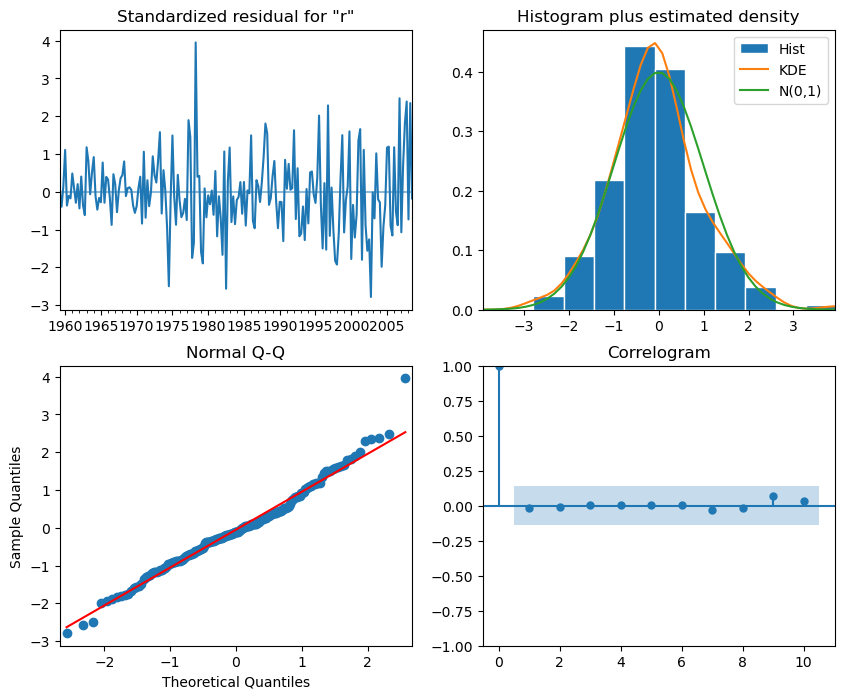

In [149]:
ARIMAX_model_all = SARIMAX(endog=df_train, exog=df_exog_all_train, order=(4,d,4), seasonal_order=(0,0,0,4), simple_differencing=False)
ARIMAX_model_all_fit = ARIMAX_model_all.fit(disp=False)
print(ARIMAX_model_all_fit.summary())
ARIMAX_model_all_fit.plot_diagnostics(figsize=(10,8));

Minimum p-value: 0.95 > 0.05
The residuals are independent and not correlated.  Like white noise!


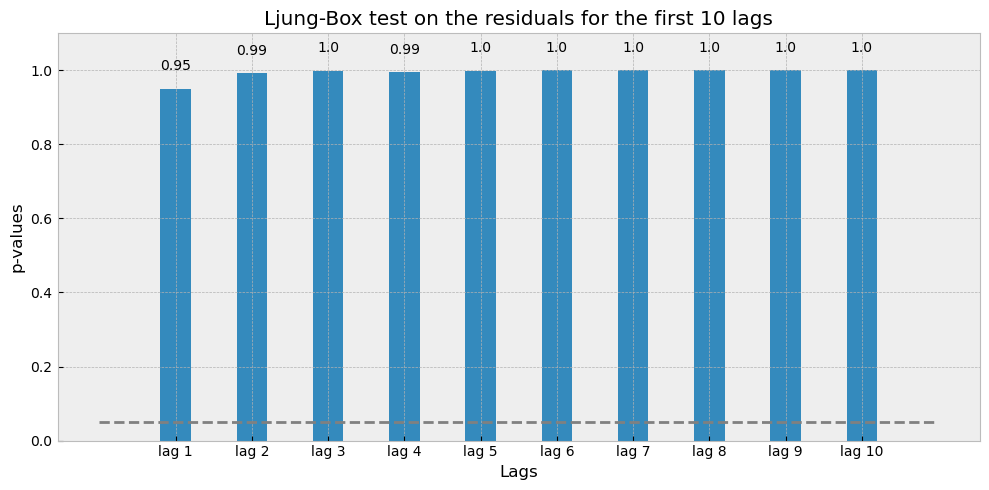

In [150]:
tt.ljungbox(np.array(ARIMAX_model_all_fit.resid), lags=10)

## Prediction

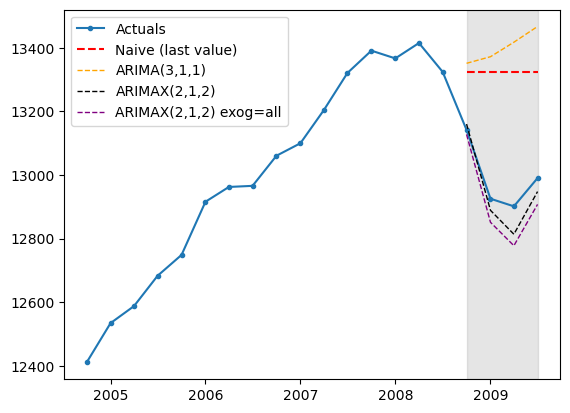

In [152]:
plt.plot(df[-20:]['realgdp'], label='Actuals', marker='o', ms=3)

df_naive = pd.DataFrame(df[-5:-4]['realgdp'].values.tolist() * 4, 
    index=df_exog[-4:].index, columns=['Forecast'])

plt.plot(df_naive, label='Naive (last value)', color='red', ls='--')

plt.plot(ARIMA_model_fit.forecast(4), 
    label='ARIMA(3,1,1)', ls='--', lw='1', color='orange')

df_exog_test = df_exog[-4:]
plt.plot(ARIMAX_model_fit.forecast(4, exog=df_exog_test),
    label='ARIMAX(2,1,2)', ls='--', lw='1', color='black')

df_exog_all_test = df_exog_all[-4:]
plt.plot(ARIMAX_model_all_fit.forecast(4, exog=df_exog_all_test),
    label='ARIMAX(2,1,2) exog=all', ls='--', lw='1', color='purple')

plt.axvspan('2008-10-01', '2009-07-01', color='#808080', alpha=0.2)
plt.legend();

## Model performance comparision

In [156]:
mape_ARIMAX_all = tt.mape(df[-4:]['realgdp'].values, ARIMAX_model_all_fit.forecast(4, exog=df_exog_all_test).values)

x = ['Naive (last value)', 'ARIMA(3,1,1)', 'ARIMAX(2,1,2)', 'ARIMAX(4,1,4) exog=all']
y = [mape_naive, mape_ARIMA, mape_ARIMAX, mape_ARIMAX_all]

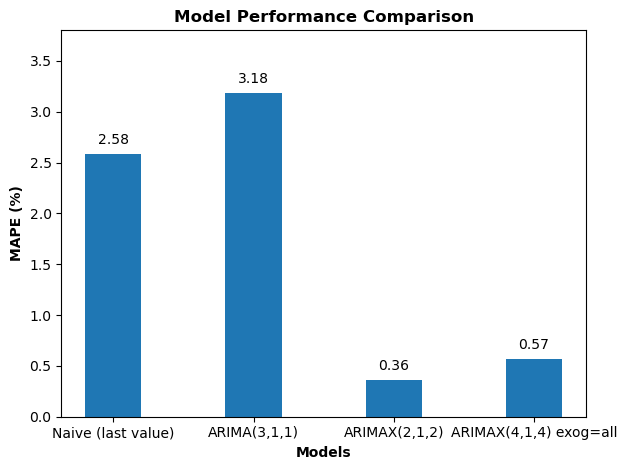

In [157]:
tt.plot_mapes(x, y, height=3.8, bar_label_height=0.1)